# IoT GNN Demo

## Env Setup
Refer to the README.

## Imports

In [1]:
from configuration import *

from models import e_graphsage, fnn_model, enhanced_e_graphsage
from data import IoTDataset
import train
from train import ModelTrainer
import tester

/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NF-BoT-IoT

## Randomized IP Addresses and Ports

### Load Data
This assumes there is a "data" folder under the root of the IoT_GNN repo.  
Datasets can be found at: https://drive.google.com/drive/folders/14t41P09gXTsCqPx3YFN1Pruwb2eZQrkT?usp=share_link

In [2]:
multiclass = True
randomized_ip_train_data = IoTDataset(version=1, multiclass=multiclass)
randomized_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val')
randomized_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test')

### Model Initialization

In [3]:
# Multiclass
model_egs = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                              )
model_fnn = fnn_model.TestFNN(num_hidden_layers=2,
                               hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                               num_edge_attr=randomized_ip_train_data.num_features,
                               num_classes=len(randomized_ip_train_data.classes),
                              )
model_egsh = enhanced_e_graphsage.Enhanced_E_GraphSAGE(numLayers=2,
                                                       dim_node_embed=128,
                                                       num_edge_attr=randomized_ip_train_data.num_features,
                                                       num_classes=len(randomized_ip_train_data.classes),
                                                       attention=False, gating=False, residual=False
                                                      )

In [4]:
# Multiclass
egs_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
fnn_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

### Training

In [5]:
# For development purposes, if the train module was modified, it can be reloaded.
import importlib
importlib.reload(train)

<module 'train' from '/home/rowleyra/IoT_GNN/train.py'>

In [6]:
# Instantiate Trainer
# Multiclass
egs_trainer = ModelTrainer(egs_training_config, randomized_ip_train_data, randomized_ip_val_data)
fnn_trainer = ModelTrainer(fnn_training_config, randomized_ip_train_data, randomized_ip_val_data)
egsh_trainer = ModelTrainer(egsh_training_config, randomized_ip_train_data, randomized_ip_val_data)

In [7]:
# Train the GNN
_ = egs_trainer.train_model(model_egs, False)

Training E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:32<00:00,  9.16epoch/s, train loss=0.6302, validation loss=0.7072, learning rate=1.00e-08, F1 score=0.75165]


In [8]:
# Train the FCNN
_ = fnn_trainer.train_model(model_fnn, False)

Training FCNN_K2: 100%|██████████| 300/300 [00:25<00:00, 11.62epoch/s, train loss=0.9981, validation loss=0.7014, learning rate=1.00e-03, F1 score=0.77047]


In [9]:
# Train the EGSH
_ = egsh_trainer.train_model(model_egsh, False)

Training Enhanced_E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:57<00:00,  5.22epoch/s, train loss=0.6418, validation loss=0.7047, learning rate=1.00e-06, F1 score=0.75202]


### Testing

In [10]:
# For development purposes, if the tester module was modified, it can be reloaded.
import importlib
importlib.reload(tester)

<module 'tester' from '/home/rowleyra/IoT_GNN/tester.py'>

In [11]:
tester_inst = tester.ModelTester(randomized_ip_test_data, True)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.188636
Recall:    0.913781
F1-score:  0.312716

== DDoS ==
Precision: 0.389628
Recall:    0.976161
F1-score:  0.556952

== DoS ==
Precision: 0.279070
Recall:    0.001056
F1-score:  0.002103

== Reconnaissance ==
Precision: 0.995111
Recall:    0.791333
F1-score:  0.881600

== Theft ==
Precision: 0.052288
Recall:    0.439791
F1-score:  0.093463

== weighted avg ==
Precision: 0.848318
Recall:    0.735702
F1-score:  0.751906

= Global Metrics =
Accuracy:           0.735702
Balanced Accuracy:  0.624424

Confusion Matrix:
[[ 2533    55     1   115    68]
 [   22 11097    10    19   220]
 [   28 11079    12    21   227]
 [10845  6250    17 74489  2530]
 [    0     0     3   211   168]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2533
TP: 106353
FN: 10895
FP: 239

Accuracy: 0.907232
Balanced Acc

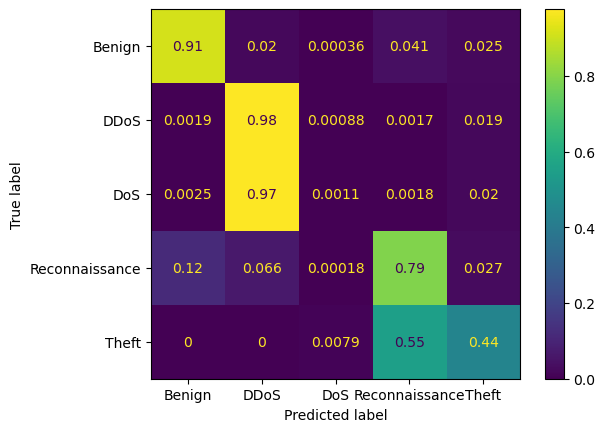

In [12]:
tester_inst.test_model(model_egs)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.209751
Recall:    0.965368
F1-score:  0.344623

== DDoS ==
Precision: 0.389766
Recall:    0.934025
F1-score:  0.550013

== DoS ==
Precision: 0.339638
Recall:    0.036333
F1-score:  0.065644

== Reconnaissance ==
Precision: 0.993957
Recall:    0.817818
F1-score:  0.897325

== Theft ==
Precision: 0.123338
Recall:    0.437173
F1-score:  0.192396

== weighted avg ==
Precision: 0.853877
Recall:    0.757007
F1-score:  0.770652

= Global Metrics =
Accuracy:           0.757007
Balanced Accuracy:  0.638143

Confusion Matrix:
[[ 2676    63     0    16    17]
 [    9 10618   391   120   230]
 [    9 10583   413   123   239]
 [10058  5978   412 76982   701]
 [    6     0     0   209   167]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2676
TP: 107166
FN: 10082
FP: 96

Accuracy: 0.915197
Balanced Accu

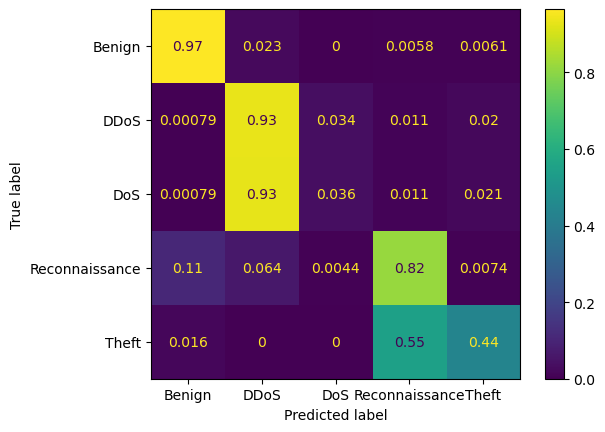

In [13]:
tester_inst.test_model(model_fnn)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.188230
Recall:    0.912698
F1-score:  0.312095

== DDoS ==
Precision: 0.389628
Recall:    0.976161
F1-score:  0.556952

== DoS ==
Precision: 0.279070
Recall:    0.001056
F1-score:  0.002103

== Reconnaissance ==
Precision: 0.995063
Recall:    0.790154
F1-score:  0.880849

== Theft ==
Precision: 0.050786
Recall:    0.439791
F1-score:  0.091057

== weighted avg ==
Precision: 0.848267
Recall:    0.734753
F1-score:  0.751295

= Global Metrics =
Accuracy:           0.734753
Balanced Accuracy:  0.623972

Confusion Matrix:
[[ 2530    55     1   118    68]
 [   22 11097    10    19   220]
 [   28 11079    12    21   227]
 [10861  6250    17 74378  2625]
 [    0     0     3   211   168]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2530
TP: 106337
FN: 10911
FP: 242

Accuracy: 0.907074
Balanced Acc

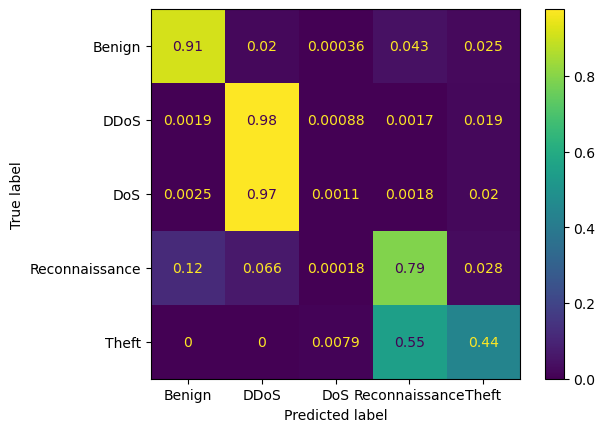

In [14]:
tester_inst.test_model(model_egsh)

## Non-Randomized IP Addresses and Ports

### Load Data

In [15]:
multiclass = True
orig_ip_train_data = IoTDataset(version=1, multiclass=multiclass, randomize_source_ip=False)
orig_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val', randomize_source_ip=False)
orig_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test', randomize_source_ip=False)

### Model Initialization

In [16]:
# Multiclass
model_egs_orig = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                              )
model_fnn_orig = fnn_model.TestFNN(num_hidden_layers=2,
                               hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                               num_edge_attr=randomized_ip_train_data.num_features,
                               num_classes=len(randomized_ip_train_data.classes),
                              )
model_egsh_orig = enhanced_e_graphsage.Enhanced_E_GraphSAGE(numLayers=2,
                                                       dim_node_embed=128,
                                                       num_edge_attr=randomized_ip_train_data.num_features,
                                                       num_classes=len(randomized_ip_train_data.classes),
                                                       attention=False, gating=False, residual=False
                                                      )

### Training

In [17]:
# Multiclass
egs_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
fnn_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [18]:
# Instantiate Trainer
# Multiclass
egs_orig_trainer = ModelTrainer(egs_training_config_orig, orig_ip_train_data, orig_ip_val_data)
fnn_orig_trainer = ModelTrainer(fnn_training_config_orig, orig_ip_train_data, orig_ip_val_data)
egsh_orig_trainer = ModelTrainer(egsh_training_config_orig, orig_ip_train_data, orig_ip_val_data)

In [19]:
# Train the GNN
_ = egs_orig_trainer.train_model(model_egs_orig, False)

Training E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:22<00:00, 13.08epoch/s, train loss=0.5335, validation loss=0.6320, learning rate=3.16e-06, F1 score=0.46201]


In [20]:
# Train the FCNN
_ = fnn_orig_trainer.train_model(model_fnn_orig, False)

Training FCNN_K2: 100%|██████████| 300/300 [00:22<00:00, 13.22epoch/s, train loss=0.9534, validation loss=0.7097, learning rate=1.00e-03, F1 score=0.79906]


In [21]:
# Train the EGSH
_ = egsh_orig_trainer.train_model(model_egsh_orig, False)

Training Enhanced_E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:24<00:00, 12.40epoch/s, train loss=0.3962, validation loss=0.6097, learning rate=3.16e-06, F1 score=0.62592]


### Testing

In [22]:
tester_inst_orig = tester.ModelTester(orig_ip_test_data, True)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.175323
Recall:    0.965866
F1-score:  0.296776

== DDoS ==
Precision: 0.153846
Recall:    0.000700
F1-score:  0.001393

== DoS ==
Precision: 0.395180
Recall:    0.994760
F1-score:  0.565649

== Reconnaissance ==
Precision: 0.997078
Recall:    0.447598
F1-score:  0.617841

== Theft ==
Precision: 0.008566
Recall:    0.977778
F1-score:  0.016983

== weighted avg ==
Precision: 0.866303
Recall:    0.467800
F1-score:  0.558212

= Global Metrics =
Accuracy:           0.467800
Balanced Accuracy:  0.677340

Confusion Matrix:
[[ 2292     3     1    59    18]
 [    8     6  8527    32     0]
 [    3    14  8543    26     2]
 [10770    13  4547 41290 35628]
 [    0     3     0     4   308]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2292
TP: 98943
FN: 10781
FP: 81

Accuracy: 0.903102
Balanced Accur

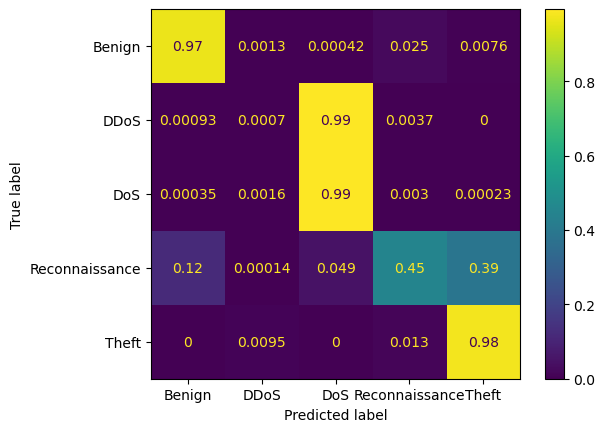

In [23]:
tester_inst_orig.test_model(model_egs_orig)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.188178
Recall:    0.964602
F1-score:  0.314921

== DDoS ==
Precision: 0.477772
Recall:    0.114079
F1-score:  0.184181

== DoS ==
Precision: 0.382402
Recall:    0.874476
F1-score:  0.532115

== Reconnaissance ==
Precision: 0.994295
Recall:    0.838880
F1-score:  0.910000

== Theft ==
Precision: 0.210526
Recall:    0.279365
F1-score:  0.240109

== weighted avg ==
Precision: 0.888647
Recall:    0.787265
F1-score:  0.811060

= Global Metrics =
Accuracy:           0.787265
Balanced Accuracy:  0.614280

Confusion Matrix:
[[ 2289     2    56    14    12]
 [    5   978  7478   110     2]
 [   11   964  7510   101     2]
 [ 9853   101  4595 77385   314]
 [    6     2     0   219    88]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2289
TP: 99849
FN: 9875
FP: 84

Accuracy: 0.911157
Balanced Accura

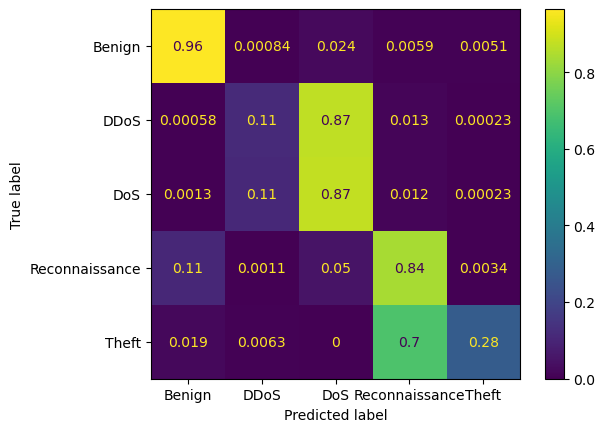

In [24]:
tester_inst_orig.test_model(model_fnn_orig)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.178243
Recall:    0.972187
F1-score:  0.301254

== DDoS ==
Precision: 0.488183
Recall:    0.433687
F1-score:  0.459324

== DoS ==
Precision: 0.345464
Recall:    0.564858
F1-score:  0.428723

== Reconnaissance ==
Precision: 0.998684
Recall:    0.592240
F1-score:  0.743544

== Theft ==
Precision: 0.013558
Recall:    0.980952
F1-score:  0.026746

== weighted avg ==
Precision: 0.889461
Recall:    0.587152
F1-score:  0.686311

= Global Metrics =
Accuracy:           0.587152
Balanced Accuracy:  0.708785

Confusion Matrix:
[[ 2307     4     0    43    19]
 [    8  3718  4815    15    17]
 [    5  3706  4851    11    15]
 [10623   185  4376 54633 22431]
 [    0     3     0     3   309]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2307
TP: 99088
FN: 10636
FP: 66

Accuracy: 0.904529
Balanced Accur

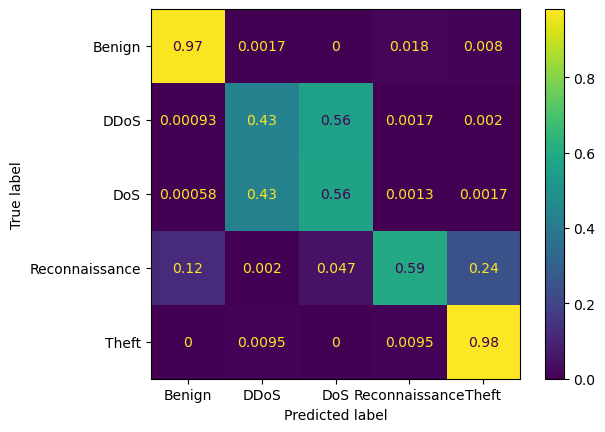

In [25]:
tester_inst_orig.test_model(model_egsh_orig)